# Cats & Dogs


This notebook serves as an exercise for learning the possibilities of **Transfer Learning** and to discover the differences between dataset size.

This notebook was made by Group 8:
- Luís Macedo, A80494
- Carlos Castro, A81946

In [1]:
import tensorflow as tf
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
import glob

from tensorflow.keras import layers, models, optimizers, metrics

## Variables

In [2]:
NCLASSES = 2
HEIGHT = 224
WIDTH = 224
NUM_CHANNELS = 3
BATCH_SIZE = 32

DATA_SET_COUNT = 10000
TEST_SET_COUNT = 2000
TRAIN_SET_COUNT = (DATA_SET_COUNT) * 0.8
VAL_SET_COUNT = (DATA_SET_COUNT) * 0.2
DATA_SET_PATH="/kaggle/input/dogsVScats/"

## Model

Load the **ResNet50** model from keras database [Keras](https://keras.io/applications/). It were used three arguments in the load:
- **include_top**, that means if the top layers (fully connected) are to be included or not;
- **weights**, the weights to be preloaded;
- **input_shape**, the input shape.

The **include_top** must be set to false for this exercise. The **weights** must be **none** or **'imagenet'**.

In [3]:
base_model = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(HEIGHT, WIDTH, NUM_CHANNELS))

94773248/94765736 [==============================] - 4s 0us/step


In [4]:
print(base_model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

If the following line of code is commented, the loaded model will not freeze the preloaded weights.

In [5]:
#base_model.trainable = False

On top of the loaded model, we included the following layers:
- Global Average Pooling 2D;
- Dense, or fully connected, with 4096 nodes as output, using the **relu** activation function;
- Dense, as the final layer, using the **sigmoid** activation function (outputs 0 or 1).

Global Average Pooling (GAP) performs an average for each of the feature maps. Assuming the last conv layer is 3x3x256, we have 256 feature maps. Global average pooling is a layer with 256 values, each being the average of a feature map.

For the last layer, we choose to use **sigmoid** because it's simpler than **softmax** for a binary answer.

In [6]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)
# x = layers.Dense(2, activation='softmax')(x)

model_3 = models.Model(inputs=base_model.input, outputs=x)
print(model_3.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## Dataset

The dataset used is from the **Kaggle** competition [dogsVScats](https://www.kaggle.com/c/dogs-vs-cats/data).

The organizations is as follow:
- train/
    - cat/
    - dog/
- test/
    - cat/
    - dog/

### Separate dogs from cats

In [ ]:
def get_label_name(file_path):
    return file_path.split(".")[0]

train_photos = glob.glob(DATA_SET_PATH + "train" + os.path.sep + "*.jpg")
    
if os.path.isdir(DATA_SET_PATH + "train" + os.path.sep + "cat") == False:
    os.mkdir(DATA_SET_PATH + "train" + os.path.sep + "cat")
    
if os.path.isdir(DATA_SET_PATH + "train" + os.path.sep + "dog") == False:
    os.mkdir(DATA_SET_PATH + "train" + os.path.sep + "dog")

for photo in train_photos:
    photo_name = photo.split(os.path.sep)[-1]
    os.replace(photo, DATA_SET_PATH + "train" + os.path.sep + get_label_name(photo_name) + os.path.sep + photo_name)

### Creating the test set

In [ ]:
path = DATA_SET_PATH + "test" + os.path.sep

if os.path.isdir(path) == False:
    os.mkdir(path)

if os.path.isdir(path + "cat") == False:
    os.mkdir(path + "cat")

if os.path.isdir(path + "dog") == False:
    os.mkdir(path + "dog")

### Taking 1000 images from each class of train to the test

In [ ]:
path = DATA_SET_PATH + "test" + os.path.sep

cats_test = glob.glob(path + "cat" + os.path.sep + "*.jpg")
if len(cats_test) == 0:
    cats = glob.glob(path + "cat" + os.path.sep + "*.jpg")
    i=0
    for cat in cats:
        if i == 1000:
            break
        i+=1
        cat_name = cat.split(os.path.sep)[-1]
        os.replace(cat, path + "cat" + os.path.sep + cat_name)

dogs_test = glob.glob(path + "dog" + os.path.sep + "*.jpg")
if len(dogs_test) == 0:
    dogs = glob.glob(path + "dog" + os.path.sep + "*.jpg")
    i = 0
    for dog in dogs:
        if i == 1000:
            break
        i+=1
        dog_name = dog.split(os.path.sep)[-1]
        os.replace(dog, path + "dog" + os.path.sep + dog_name)

### Auxiliary function for loading the dataset
Because **sigmoid** receives label with shape=(1), meaning that is a number. So, we dictated that 0 represent cats and 1 represent dogs.

In [7]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    if parts[-2]=="cat":
        return 0
    else:
        return 1

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_png(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [WIDTH, HEIGHT])

def get_bytes_and_label(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

### Load the dataset

Replace the path with your own location of the dataset

In [8]:
classNames = np.array(['cat', 'dog'])

AUTOTUNE = tf.data.experimental.AUTOTUNE

listset = tf.data.Dataset.list_files(DATA_SET_PATH + "split" + DATA_SET_COUNT + "/*/*.jpg")
dataset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)


### Split the dataset into training and validation sets

In [9]:
dataset = dataset.prefetch(buffer_size=AUTOTUNE)
dataset = dataset.repeat()

train_size = int(TRAIN_SET_COUNT)
val_size = int(VAL_SET_COUNT)

train_dataset = dataset.take(train_size)
train_dataset = train_dataset.shuffle(buffer_size = train_size)
train_dataset = train_dataset.batch(batch_size=BATCH_SIZE)
train_dataset = train_dataset.repeat();

val_dataset = dataset.skip(train_size)
val_dataset = val_dataset.batch(batch_size=BATCH_SIZE)
val_dataset = val_dataset.repeat();


### Load the test set

In [10]:
testset = tf.data.Dataset.list_files(DATA_SET_PATH + "test/*/*.jpg")
testset = testset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
testset = testset.batch(batch_size=BATCH_SIZE)


### Show a batch of images from the dataset

In [11]:
def show_batch(image_batch, label_batch):
    columns = 6
    rows = BATCH_SIZE / columns + 1  
    plt.figure(figsize=(10, 2 * rows))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(rows, columns, n+1)
        plt.imshow((image_batch[n]))
        plt.title(classNames[label_batch[n]==1][0])
        plt.axis('off')
        
        
image_batch, label_batch = next(iter(train_dataset))  
show_batch(image_batch, label_batch.numpy())

## Train the model for 20 epochs

We used the **binary_crossentropy** as the loss function and a binary accuracy for more precision.

In [12]:
# model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[ metrics.categorical_accuracy])
# model_3 = models.Model(inputs=base_model.input, outputs=x)

model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=[metrics.binary_accuracy])
history = model_3.fit(train_dataset, epochs=20, steps_per_epoch=train_size/BATCH_SIZE, validation_data = val_dataset, validation_steps= val_size/BATCH_SIZE)

Train for 250.0 steps, validate for 62.5 steps
Epoch 1/20
250/250 [==============================] - 112s 447ms/step - loss: 0.3673 - binary_accuracy: 0.8687 - val_loss: 0.7825 - val_binary_accuracy: 0.5094
Epoch 2/20
250/250 [==============================] - 78s 312ms/step - loss: 0.1745 - binary_accuracy: 0.9284 - val_loss: 0.9790 - val_binary_accuracy: 0.5064
Epoch 3/20
250/250 [==============================] - 77s 309ms/step - loss: 0.1454 - binary_accuracy: 0.9435 - val_loss: 0.6584 - val_binary_accuracy: 0.5516
Epoch 4/20
250/250 [==============================] - 76s 305ms/step - loss: 0.1281 - binary_accuracy: 0.9475 - val_loss: 0.5297 - val_binary_accuracy: 0.7445
Epoch 5/20
250/250 [==============================] - 78s 314ms/step - loss: 0.1083 - binary_accuracy: 0.9554 - val_loss: 0.3468 - val_binary_accuracy: 0.8075
Epoch 6/20
250/250 [==============================] - 78s 310ms/step - loss: 0.1048 - binary_accuracy: 0.9607 - val_loss: 0.8320 - val_binary_accuracy: 0.573

## Show how the learning progressed

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


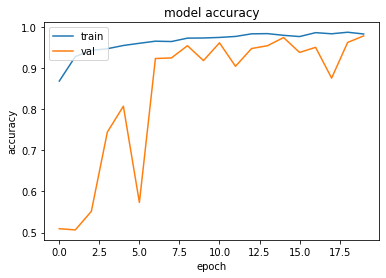

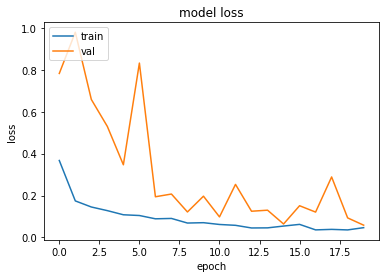

In [13]:
print(history.history.keys())

# summarize history for accuracy
#plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluate the model on the testset

In [14]:
model_3.evaluate(testset)

63/63 [==============================] - 6s 90ms/step - loss: 0.2204 - binary_accuracy: 0.9400: 2s - loss: 0.2159


[0.2203580503987651, 0.94]

## Tests

| Dataset size | Last Dense | weights  | Freeze | Accuracy |
|--------------|------------|----------|--------|----------|
| 250          | Softmax    | none     | no     | 0.503    |
| 250          | Softmax    | imagenet | no     | 0.5      |
| 250          | Softmax    | imagenet | yes    | 0.5      |
|--------------|------------|----------|--------|----------|
| 2500         | Softmax    | none     | no     | 0.579    |
| 2500         | Softmax    | imagenet | no     | 0.799    |
| 2500         | Softmax    | imagenet | yes    | 0.5      |
|--------------|------------|----------|--------|----------|
| 5000         | Softmax    | none     | no     | 0.7165   |
| 5000         | Softmax    | imagenet | no     | 0.886    |
| 5000         | Softmax    | imagenet | yes    | 0.473    |
|--------------|------------|----------|--------|----------|
| 10 000       | Softmax    | none     | no     | 0.746    |
| 10 000       | Softmax    | imagenet | no     | 0.916    |
| 10 000       | Softmax    | imagenet | yes    | 0.491    |
|--------------|------------|----------|--------|----------|
| 15 000       | Softmax    | none     | no     | 0.8545   |
| 15 000       | Softmax    | imagenet | no     | 0.8765   |
| 15 000       | Softmax    | imagenet | yes    | 0.5      |
|--------------|------------|----------|--------|----------|
| 10 000       | sigmoid    | none     | no     | 0.821    |
| 10 000       | sigmoid    | imagenet | no     | 0.94     |
| 10 000       | sigmoid    | imagenet | yes    | 0.496    |




The highest accuracy we get was: using **sigmoid** in the last Dense, training with 10 000 images, using the weights of **imagenet** without freezing the convolution weights.

Through the analysis of the tests made, we concluded that using the preloaded weights without freezing the convolution weights get the best results, and as expected, the bigger the dataset, the better are the results, up to a limit. In other words, the accuracy increased with the increasement of the dataset, up to 10 000 images. We only tested a dataset with more images than 10 000, which had a worse accuracy.